In [1]:
import numpy as np;
import torch 
from PIL import Image
import os 
from torchvision  import datasets, transforms
from torch.utils.data import DataLoader, random_split; 
import matplotlib.pyplot as plt
import torch.nn as nn; 
import torch.optim as optim; 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve,  auc
from sklearn.preprocessing import label_binarize
import time 


In [ ]:
transform = transforms.Compose([
    
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])



In [ ]:
data_dir = './Datasets/LungXRays-grayscale'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
 
image, label = test_dataset[0]; 
print(image.shape)

torch.Size([3, 224, 224])


In [ ]:
## making the datasets loading 
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True); 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
images, labels =next(dataiter)
print(torch.min(images), torch.max(images))



tensor(-1.) tensor(1.)


In [ ]:
class SimpleCNN(nn.Module): #* a proposed Customize CNN
    def __init__(self, num_classes = 4):
        super(SimpleCNN, self).__init__()
        
        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,  padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 28 * 28, 512), #* making  the flatten
            nn.ReLU(), 
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(), 
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )
        
        
    def forward(self, x): 
        x = self.features(x); 
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        

In [ ]:

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SimpleCNN().to(device) 
criterion = nn.CrossEntropyLoss();  
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epoch = 20

In [ ]:


def train_model(model, train_loader, criterion, optimizer, device):
     
    
    model.train(); 
    learning_loss = 0.0; 
    correct = 0; 
    total = 0; 
    
    for inputs, labels in train_loader: 
        
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs); 
        loss = criterion(outputs, labels); 
        loss.backward();
        optimizer.step(); 
        learning_loss += loss.item(); 
        _, predict = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item(); 
    
    learning_loss_result = learning_loss / total if total > 0 else 0
    train_acc = 100 * correct /total if total > 0 else 0
    return learning_loss_result, train_acc              

In [ ]:

def validation(model, val_loader, criterion, device ): 
    model.eval(); 
    running_loss = 0.0; 
    total = 0; 
    correct = 0; 

    with torch.no_grad(): 
        for inputs, labels in val_loader: 
            inputs, labels = inputs.to(device), labels.to(device); 
            outputs = model(inputs); 
            loss = criterion(outputs, labels); 
            running_loss += loss.item(); 
            _,predict = torch.max(outputs, 1); 
            
            total  += labels.size(0); 
            correct  += (predict == labels).sum().item()
            
    result_running_loss = running_loss / total if total > 0 else 0 
    result_val_acc = 100* correct / total if total > 0 else 0; 
    return  result_running_loss, result_val_acc; 

In [ ]:
 
class EarlyStopping: #* applied Early stopping technique  to prevent overfitting
    def __init__(self, patience=5, verbose = False, delta = 0,  path= 'best.pt' ):
        self.patience = patience
        self.verbose = verbose 
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta
        self.path = path 
        
    def __call__(self, val_loss, model):
        
        if  self.best_loss is None or val_loss < self.best_loss - self.delta:
            
            if self.verbose:
                if self.best_loss is None:
                    print(f"Validation loss set to {val_loss:.4f} for the first time. Saving model.")
                else:
                    print(f"Validation loss decreased from {self.best_loss:.4f} to {val_loss:.4f}. Saving model.")
            self.Save_best_model(model)
            self.counter = 0
            
        else: 
            self.counter += 1 
            
            if self.verbose: 
                print(f'Early stopping Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        
    
    def Save_best_model(self, model): 
        torch.save(model.state_dict(), self.path)
                
   
        

In [ ]:
earlyStopping = EarlyStopping(patience=5, verbose=True, path='best_simpleCNN.pth')
start_time = time.time()
train_losses, train_accs, val_losses, val_accs =[], [], [], []
for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validation(model, val_loader, criterion, device)
    train_losses.append(train_loss); 
    train_accs.append(train_acc); 
    val_losses.append(val_loss)
    val_accs.append(val_acc); 
    epoch_end_time = time.time()
    
    print(f'Epoch {epoch+1}/{num_epoch}: Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    earlyStopping(val_loss, model)
    if earlyStopping.early_stop: 
        print('Note early stopping is triggered no need more training')
        break
end_time = time.time()
print(f'Training Time for customCnn: {end_time - start_time:.2f} seconds')

Epoch 1/20: Train Loss: 0.0269 Train Acc: 62.7854, Val Loss: 0.0187, Val Acc: 75.9877
Validation loss set to 0.0187 for the first time. Saving model.
Epoch 2/20: Train Loss: 0.0181 Train Acc: 77.8441, Val Loss: 0.0144, Val Acc: 83.3333
Validation loss set to 0.0144 for the first time. Saving model.
Epoch 3/20: Train Loss: 0.0144 Train Acc: 82.7402, Val Loss: 0.0125, Val Acc: 85.5556
Validation loss set to 0.0125 for the first time. Saving model.
Epoch 4/20: Train Loss: 0.0128 Train Acc: 85.0237, Val Loss: 0.0115, Val Acc: 86.2346
Validation loss set to 0.0115 for the first time. Saving model.
Epoch 5/20: Train Loss: 0.0112 Train Acc: 86.7311, Val Loss: 0.0130, Val Acc: 84.9383
Validation loss set to 0.0130 for the first time. Saving model.
Epoch 6/20: Train Loss: 0.0103 Train Acc: 88.2534, Val Loss: 0.0094, Val Acc: 88.7037
Validation loss set to 0.0094 for the first time. Saving model.
Epoch 7/20: Train Loss: 0.0092 Train Acc: 89.2820, Val Loss: 0.0095, Val Acc: 89.5062
Validation los

In [13]:
model = SimpleCNN(num_classes=4).to(device)   
model.load_state_dict(torch.load('best_simpleCNN.pth'))

/var/folders/4g/tf_931w11w99w336_dt_g9740000gn/T/ipykernel_17330/3191803658.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_simple

<All keys matched successfully>

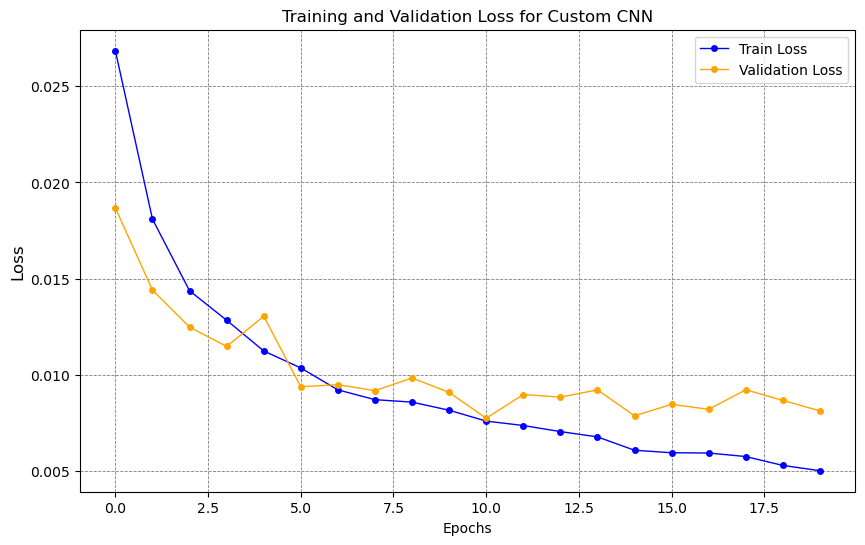

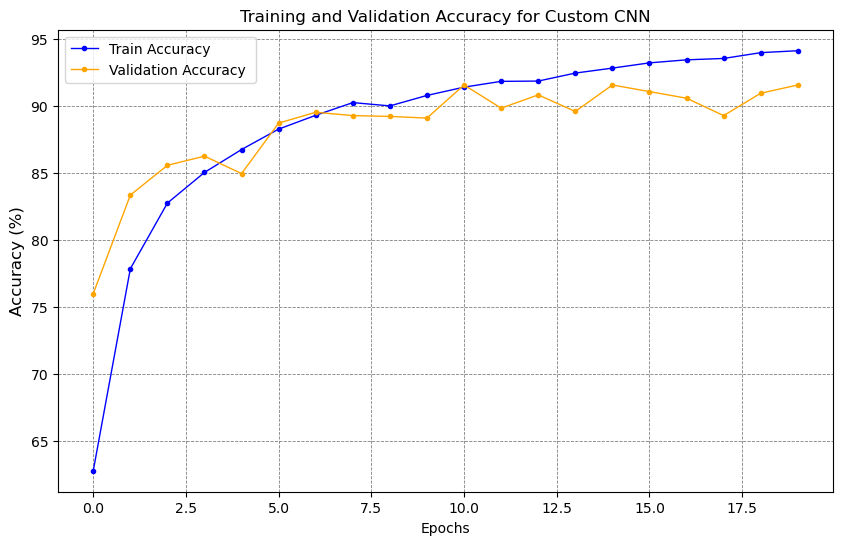

In [ ]:
def Plot_metrics(train_losses, val_losses, train_accs, val_accs):
    
    epoch = list(range(0, num_epoch))
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_losses, label= 'Train Loss', color = 'blue',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.plot(epoch, val_losses, label='Validation Loss', color='orange',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss for Custom CNN')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()
    

    epoch = list(range(0, num_epoch))
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_accs, label= 'Train Accuracy ', color = 'blue',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.plot(epoch, val_accs, label='Validation Accuracy ', color='orange',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Training and Validation Accuracy for Custom CNN')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()



Plot_metrics(train_losses, val_losses, train_accs, val_accs)
    

In [15]:
def evaluation(model, test_loader, criterion, device):
    test_loss = 0.0
    all_pred = []
    all_labels = []
    all_probs = []   
    correct = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
       
            _, predicted = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
            all_pred.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
  
    result_test_loss = test_loss / len(test_loader)
    result_test_acc = 100 * correct / total
    
     
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs) 
    num_classes = all_probs.shape[1]
    y_true = label_binarize(all_labels, classes=range(num_classes))
    auc = roc_auc_score(y_true, all_probs, multi_class='ovr', average='macro')
    
    
    return result_test_loss, result_test_acc, all_pred, all_labels, auc, all_probs

In [31]:
test_loss, test_acc, all_preds, all_labels, auc, all_probs= evaluation(model, test_loader, criterion, device)
print(f'Test Accuaracy: {test_acc:.2f}% AUC: {100*auc:.2f}%')

Test Accuaracy: 92.55% AUC: 99.22%


Accuracy: 0.9280

 classification Report
              precision    recall  f1-score   support

     COVID19     0.9165    0.9419    0.9290       396
      Normal     0.9208    0.9163    0.9185       406
   Pneumonia     0.9484    0.8853    0.9158       436
Tuberculosis     0.9263    0.9742    0.9496       387

    accuracy                         0.9280      1625
   macro avg     0.9280    0.9294    0.9282      1625
weighted avg     0.9285    0.9280    0.9277      1625



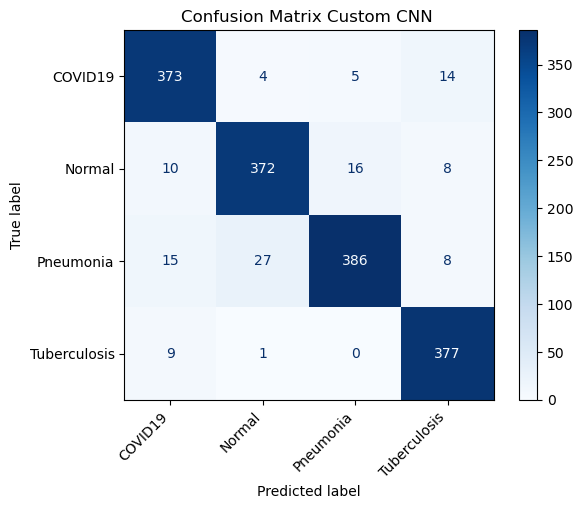

In [29]:
## Confusion metrics 
accuracy = accuracy_score(all_preds, all_labels)
print(f"Accuracy: {accuracy:.4f}")
print('\n classification Report')
cls_report = classification_report(all_preds, all_labels, target_names=train_dataset.classes, digits=4)
print(cls_report)

cm = confusion_matrix(all_preds, all_labels)

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
display.plot(cmap='Blues')
plt.xticks(rotation = 45, ha= 'right')
plt.title('Confusion Matrix Custom CNN ')
plt.show()

In [36]:
#* plotting auc curve for each classes 

def plot_roc_curve(all_labels, all_probs, num_classes, class_names):
    
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    
    y_true = label_binarize(all_labels, classes=range(num_classes))
    all_probs = np.array(all_probs)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

 
    plt.figure(figsize=(4, 4))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve for Custom CNN')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


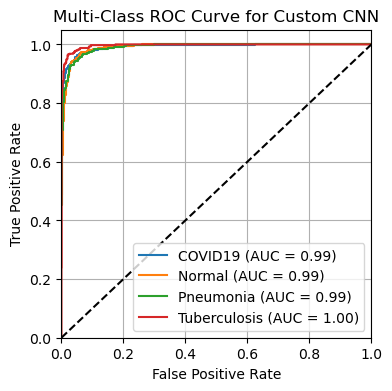

In [ ]:
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes   
plot_roc_curve(all_labels, all_probs, num_classes, class_names)